In [4]:
import os
import json
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import pickle
from utils import show
from PIL import Image
from torch.utils.data import Dataset
from utils import initialize_weights
import cv2
%matplotlib inline

In [5]:
def train(train_loader,model,model2,optimizer,optimizer2,loss_func,classes,device):
    total_loss=0
    for i,(images,targets) in enumerate(train_loader):
        images=images.to(device)
        targets=targets.to(device)
        outputs=model(images)
        outputs=model2(outputs)
        #print(outputs,targets)
        loss=loss_func(outputs,targets)
        optimizer.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer2.step()
        total_loss=loss+total_loss
    return total_loss/len(train_loader)
def run_train(trainloader,model,model2,optimizer,optimizer2,loss_func,classes,n_epochs,device):
    loss_list=[]
    for epoch in range(n_epochs):
        loss=train(trainloader,model,model2,optimizer,optimizer2,loss_func,classes,device)
        print('Epoch {}: Loss: {:.4f} '.format(epoch,loss))
        loss_list.append(loss)
    return loss_list

In [6]:
transform=transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
def save_model(model,save_path):
    torch.save(model.state_dict(), save_path)
def denorm(x):
    out=(x+1)/2
    return out.clamp(0, 1)
def load_data(transform):
    ds=torchvision.datasets.ImageFolder('./data/object', transform)
    return ds

In [7]:
#train model
train_dataset=load_data(transform)
#print(train_dataset)
classes=len(train_dataset.class_to_idx)
idx_to_class={}
for each in train_dataset.class_to_idx:
    idx_to_class[train_dataset.class_to_idx[each]]=each
f = open('idx_to_class.txt', 'wb')
pickle.dump((classes,idx_to_class), f)
f.close()
torch.cuda.empty_cache()
learning_rate=0.0002
betas=(0.5,0.999)
device=torch.device('cuda:0')
batch_size=2
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,drop_last=True,shuffle=True)
model=models.resnet50().to(device)
model2=nn.Linear(1000,classes).to(device)
optimizer=optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
optimizer2=optim.Adam(model2.parameters(), lr=learning_rate, betas=betas)
loss_func=nn.CrossEntropyLoss().to(device)
n_epochs=100
loss_list=run_train(train_loader,model,model2,optimizer,optimizer2,loss_func,classes,n_epochs,device)
save_model(model,'trained_model_1.pth')
save_model(model2,'trained_model_2.pth')

Epoch 0: Loss: 3.2111 
Epoch 1: Loss: 2.2397 
Epoch 2: Loss: 1.0155 
Epoch 3: Loss: 1.8500 
Epoch 4: Loss: 0.6778 
Epoch 5: Loss: 1.4162 
Epoch 6: Loss: 1.4597 
Epoch 7: Loss: 1.0456 
Epoch 8: Loss: 0.7531 
Epoch 9: Loss: 0.8983 
Epoch 10: Loss: 1.1109 
Epoch 11: Loss: 1.4725 
Epoch 12: Loss: 0.6387 
Epoch 13: Loss: 1.0647 
Epoch 14: Loss: 0.8926 
Epoch 15: Loss: 0.8665 
Epoch 16: Loss: 0.7887 
Epoch 17: Loss: 0.2692 
Epoch 18: Loss: 0.8874 
Epoch 19: Loss: 0.3663 
Epoch 20: Loss: 0.3662 
Epoch 21: Loss: 0.8867 
Epoch 22: Loss: 0.5988 
Epoch 23: Loss: 0.9836 
Epoch 24: Loss: 0.7785 
Epoch 25: Loss: 0.3533 
Epoch 26: Loss: 0.8072 
Epoch 27: Loss: 1.0853 
Epoch 28: Loss: 0.2670 
Epoch 29: Loss: 0.5612 
Epoch 30: Loss: 0.4480 
Epoch 31: Loss: 0.3830 
Epoch 32: Loss: 0.3064 
Epoch 33: Loss: 0.2432 
Epoch 34: Loss: 0.4714 
Epoch 35: Loss: 0.1272 
Epoch 36: Loss: 0.2968 
Epoch 37: Loss: 0.2718 
Epoch 38: Loss: 0.1097 
Epoch 39: Loss: 0.1247 
Epoch 40: Loss: 0.1713 
Epoch 41: Loss: 0.0553 
Ep

predict object is : 花露水
predict object is : 饮料盒
predict object is : 纸袋


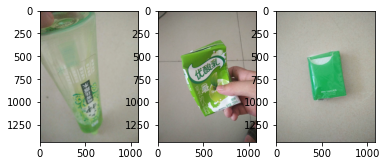

In [16]:
#use model
with open('idx_to_class.txt', 'rb') as f:
    classes,dic=pickle.load(f,encoding='bytes')
device=torch.device('cuda:0')
def get_result(model,model2,pics,device):
    for i in range(len(pics)):
        pics[i]=transform(pics[i]).to(device)
    pics=torch.stack(pics,0).to(device)
    outputs=model(pics)
    outputs=model2(outputs)
    #outputs=torch.sigmoid(outputs)
    #outputs=torch.div(outputs,(outputs.sum(dim=-1)).unsqueeze(-1))
    return outputs
img_path='test3.jpg'
model=models.resnet50(pretrained=True).to(device)
model.load_state_dict(torch.load('trained_model_1.pth'))
model2=nn.Linear(1000,classes).to(device)
model2.load_state_dict(torch.load('trained_model_2.pth'))
model.eval()
model2.eval()
plt.figure()
for i in range(1,4):
    img_path='test'+str(i)+'.jpg'
    pic=plt.imread(img_path)
    plt.subplot(1,3,i)
    plt.imshow(pic)
    pic=Image.fromarray(pic)
    pics=[]
    pics.append(pic)
    result=get_result(model,model2,pics,device)
    #print(result)
    print('predict object is :',dic[result.argmax().item()])
plt.show()